# NLP Project 2, Seek dataset Category and Job Type Classification
22274048, 

First, import all required libraries and modules for the project and load the data into pandas

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import collections
import numpy as np
import pandas as pd
import re
import os
from collections import Counter
import string
from argparse import Namespace
import torch.nn as nn
from torch.utils.data import Dataset
import random
import os
import torch.optim as optim
import json
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import unicodedata
import ftfy
from gensim.models import KeyedVectors
import gensim
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import Word2Vec
import seaborn as sns
from time import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from nltk.corpus import stopwords
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))

In [ ]:
df_args = Namespace(
    unprocessed_csv  = os.path.join(script_dir, 'data/seek_australia.csv'),
    processed_csv = os.path.join(script_dir, 'data/processed_seek.csv'),
    train_proportion=0.7,
    val_proportion=0.1,
    test_proportion=0.2,
    frac = 1, # change to 1 to use the full dataset
)

In [ ]:
df = pd.read_csv (df_args.unprocessed_csv)
df = df.sample(frac=df_args.frac, ignore_index=True, random_state=1) # this also shuffles the dataframe
df

,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
0,Healthcare & Medical,Brisbane,H1 Healthcare Pty,AU,seek,Are you a scrub nurse looking to escape the p...,Registered Nurse (RN),Full Time,2018-04-12T05:05:22Z,$75k - $85k p.a. + more,NaN,https://www.seek.com.au/job/35969937
1,Trades & Services,"Bendigo, Goldfields & Macedon Ranges",RedHill Designer Cabinetry,AU,seek,RedHill Designer Cabinetry is a Bendigo-based...,Cabinet Maker,Full Time,2018-04-14T04:34:11Z,Salary negotiable based on experience,NaN,https://www.seek.com.au/job/35986382
2,Administration & Office Support,Sydney,Active Recruitment Pty Ltd,AU,seek,NaN,Administration/ Member Services Support Office...,Full Time,2018-04-13T03:00:20Z,NaN,Parramatta & Western Suburbs,https://www.seek.com.au/job/35978573
3,Sport & Recreation,Sydney,Orangetheory Fitness Concord,AU,seek,BURN FOR THE BEST / BURN WITH THE BEST About ...,Head Trainer,Full Time,2018-04-16T23:46:33Z,"$55,000 - $70,000","CBD, Inner West & Eastern Suburbs",https://www.seek.com.au/job/36001340
4,Trades & Services,Sydney,Frontline HR Sydney,AU,seek,NaN,Heavy Diesel Mechanic,Casual/Vacation,2018-04-16T01:48:19Z,$35 - $44.99 per hour,Parramatta & Western Suburbs,https://www.seek.com.au/job/35693245
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,Healthcare & Medical,Cairns & Far North,Torres and Cape Hospital and Health Service,AU,seek,"Remuneration value up to $74,438 p.a., compri...",Advanced Health Worker Men's & Women's Health,Contract/Temp,2018-04-13T05:40:06Z,NaN,NaN,https://www.seek.com.au/job/35981838
29996,Trades & Services,Brisbane,Nobul,AU,seek,Nobul are looking for experienced Cabinet Make...,Cabinet Maker,Full Time,2018-04-13T20:30:18Z,NaN,Northern Suburbs,https://www.seek.com.au/job/35985627
29997,Administration & Office Support,Sydney,Hays Office Support,AU,seek,"Leading Asian Bank, $75,000-$85,000 package. ...",Executive Team Assistant,Full Time,2018-04-16T07:43:51Z,NaN,"CBD, Inner West & Eastern Suburbs",https://www.seek.com.au/job/35998159
29998,CEO & General Management,Cairns & Far North,Enterprise Management Group,AU,seek,Your new company At My Pathway we believe eve...,Chief Operating Officer,Full Time,2018-04-13T02:13:34Z,NaN,NaN,https://www.seek.com.au/job/35977902


## Data preprocessing

#### Preparing the dataframe for classification

Remove unnecessary columns

In [ ]:
features_to_delete = ['job_board','geo','url', 'city', 'post_date', 'salary_offered', 'state', "company_name", "job_title"] # get rid of unnecessary features (maybe add more columns)
df = df.drop(features_to_delete, axis=1)

Retrieve the number of null values in each column

In [ ]:
df.isna().sum()

category             0
company_name         0
job_description    345
job_title            0
job_type             0
dtype: int64

Job description is the feature columns and will be used for all the classification tasks, thus all rows that are missing values for the column can be dropped

In [ ]:
df.dropna(subset=['job_description'], inplace=True)

Decode the text in the job description column and use gensim for tokenization

In [ ]:
for i in df[ "job_description"].index:
    df.loc[i, "job_description"] = gensim.utils.simple_preprocess(
        ftfy.fix_text(unicodedata.normalize("NFKD",df.loc[i,"job_description"])), deacc=True)

Create_tfidf function creates a dataframe with each row representing a document with corresponding tfidf scores and the columns showing the full corpus vocabulary. Thus the tfidf score for each word in each document can be looked up.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Allows passing tokens to the vectorizer
def dummy_fun(doc):
    return doc

def create_tfidf_df(tokens):  
    """
    Returns a bag of words data frame to fetch the tfidf score for each document
    tokens: the corpus as a list of tokens
    """
   
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english')
    tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    stop_words=stopwords) 

    tdf = tfidf.fit_transform(tokens)
    bow = pd.DataFrame(tdf.toarray(), columns = tfidf.get_feature_names_out())

    return bow

Top x tfidf accepts a list of tokenized documents and removes all words that do not have the top x tfidf scores. Removes all words that do not have the top 10 tfidf scores. Treats each category as its own corpus

In [ ]:
df['short_description'] = [None for i in range(len(df))]
def top_x_tfidf(df, x):
    """
    df is the dataframe to modify, x represents the top x words to leave in each document. Returns a list of documents as tokens. 
    """
    for category in df.category.unique():
        tfidf_df = create_tfidf_df(df[df.category == category]['job_description'])
        col_names= set(tfidf_df.columns)
        for i, (idx_row) in enumerate(df[df.category == category].iterrows()):
            idx, row = idx_row
            desc = row['job_description']
            words = set(desc)        
            if len(words) < x: 
                df.loc[idx]['short_description'] = words
                continue
            words = words.intersection(col_names)

            # Create a dictionary of words and their tfidf values and then sort them in descending order
            tfidf_words = {word: tfidf_df.iloc[i][word] for word in words}
            tfidf_words = {k: v for k, v in sorted(tfidf_words.items(), key=lambda item: -item[1])}

            for word in desc:
                if word not in list(tfidf_words.keys())[:x]: # Remove all words who are not in the top ten tfidf scores
                    desc = list(filter(lambda x: x != word, desc))
            df.loc[idx]['short_description'] = desc
    return df['short_description']
df['short_description'] = top_x_tfidf(df, 10)
df['short_description']

0        [the, and, to, to, the, and, to, to, the, mark...
1        [westpoint, ford, hoppers, crossing, mins, the...
2        [linkforce, and, maintenance, shutdown, and, t...
3        [who, for, who, to, the, and, the, for, to, cu...
4        [central, qld, coal, mine, coal, and, mine, si...
                               ...                        
29995    [boilermaker, heavy, fabrication, trs, resourc...
29996    [underground, diamond, drilling, underground, ...
29997    [the, er, on, the, on, the, the, advising, on,...
29998    [skycity, darwin, the, the, gaming, darwin, ga...
29999    [burn, the, burn, the, orangetheory, fitness, ...
Name: short_description, Length: 29655, dtype: object

Prepare the job type column for binary classification

In [ ]:
df.rename(columns = {'job_type': 'job_type_target'}, inplace=True) # Specify the target column
df.loc[df['job_type_target'] != 'Full Time', 'job_type_target'] = 'Other'

Observe the distribution of classes in the target column

<AxesSubplot:>

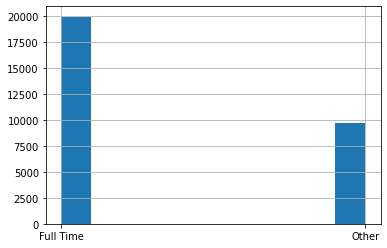

In [ ]:
df['job_type_target'].hist()

In [ ]:
df['job_type_target'].value_counts()

Full Time    19952
Other         9703
Name: job_type_target, dtype: int64

Now we can define the baseline accuracy for the models as below: 

In [ ]:
1970/len(df)

0.06643061878266734

Now split the data frame into train, test and validation then write the dataframe into a csv.

In [ ]:
n = len(df)
n_train = int(df_args.train_proportion*n)
n_val = int(df_args.val_proportion*n)
n_test = int(df_args.test_proportion*n)

df['split'] = ['nil' for i in range(len(df))]

for idx, _ in df[:n_train].iterrows():
    df.loc[idx]['split'] = 'train'
for idx, _ in df[n_train:n_train+n_val].iterrows():
    df.loc[idx]['split'] = 'val'
for idx, _ in df[n_train+n_val:].iterrows():
    df.loc[idx]['split'] = 'test' 
df['split'].value_counts()

train    20758
test      5932
val       2965
Name: split, dtype: int64

In [ ]:
df.job_description = df.job_description.apply(lambda x: ' '.join(x))
df.short_description = df.short_description.apply(lambda x: ' '.join(x)) # lists cannot be stored in csv
df.to_csv(df_args.processed_csv, index=False)
df

,category,company_name,job_description,job_title,job_type_target,short_description,split
0,Marketing & Communications,Kelly Services,the company an enterprise cloud computing lead...,Marketing Associate,Full Time,the and to to the and to to the marketing and ...,train
1,Sales,Westpoint Ford,westpoint ford is located in hoppers crossing ...,Car Salesperson New and Used,Full Time,westpoint ford hoppers crossing mins the westg...,train
2,"Mining, Resources & Energy",Linkforce Engineering,linkforce engineering is an australian owned a...,"Port Hedland Trades Persons, Scaffolders & TAs",Other,linkforce and maintenance shutdown and to and ...,train
3,Call Centre & Customer Service,Recruit2You,our client is sales company based in bondi jun...,Call Centre Staff - Looking for a New Challeng...,Other,who for who to the and the for to customer ser...,train
4,Accounting,Beilby Consulting,our client is the operating owner of central q...,Mine Site Accountant,Full Time,central qld coal mine coal and mine site centr...,train
...,...,...,...,...,...,...,...
29995,Trades & Services,TRS Resourcing,boilermaker heavy fabrication day shift per ho...,Boilermaker - Heavy Fabrication (Day Shift $40...,Other,boilermaker heavy fabrication trs resourcing t...,test
29996,"Mining, Resources & Energy",Crest Personnel Pty Ltd,underground diamond driller our client an inte...,Underground Diamond Drillers - Immediate Start!,Full Time,underground diamond drilling underground diamo...,test
29997,Human Resources & Recruitment,Peoplecorp,the organisation our client is well known orga...,ER Specialist,Full Time,the er on the on the the advising on standards...,test
29998,Hospitality & Tourism,SKYCITY Darwin,skycity darwin is the ultimate entertainment d...,Full time Surveillance Operator - SKYCITY Darwin,Full Time,skycity darwin the the gaming darwin gaming an...,test


Load the dataframe if already saved

In [ ]:
df = pd.read_csv(df_args.processed_csv)
df.short_description = df.short_description.apply(lambda x: x.split(' '))
df.job_description = df.job_description.apply(lambda x: x.split(' '))

## Vectorization

In [ ]:
vectorizer_args = Namespace(
    load_word2vec = True,
    word2vec_model_filepath = os.path.join(script_dir, 'model_storage/word2vec'),
)

#### Loading the pretrained glove model

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_pretrained = api.load("glove-wiki-gigaword-100")
    print("Loaded vocab size %i" % len(wv_pretrained))
    print("The loaded object is of type %s" % str(type(wv_pretrained)))
    return wv_pretrained
glove_model = load_embedding_model()

Loaded vocab size 400000
The loaded object is of type <class 'gensim.models.keyedvectors.KeyedVectors'>


### Word embedding visualization with tsne and word2vec

First train or load a domain specific word2vec model

In [ ]:
if vectorizer_args.load_word2vec:
    word2vec_model = model = Word2Vec.load(vectorizer_args.word2vec_model_filepath)

else:
    # Configuration was taken from labs
    word2vec_model = Word2Vec(min_count=1,
                        window=2, # We are trying to find "Full time"
                        vector_size=100,
                        sample=6e-5, 
                        alpha=0.03, 
                        min_alpha=0.0007, 
                        negative=20,
                        workers=15)

    t = time()

    word2vec_model.build_vocab(df['job_description'], progress_per=10)

    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
    t = time()

    word2vec_model.train(df['job_description'], total_examples=word2vec_model.corpus_count, epochs=1000, report_delay=1)
    word2vec_model.save('./model_storage/word2vec')
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Define some functions to help with plotting the words

In [ ]:
def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # Define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=700, plot_height=700)

    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

In [ ]:
def display_closestwords_tsnescatterplot(model, word, vec_length):
    
    arr = np.empty((0,vec_length), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.title(f'Words closest to: {word}')
    plt.show()

Below plot shows the distribution of some example words of the domain specific word2vec that was trained previously

In [ ]:
vocab  = list(word2vec_model.wv.key_to_index.keys())[:100]
random.shuffle(vocab)
vocab = [word for word in vocab if word not in stopwords]
X = word2vec_model.wv[vocab]
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
interactive_tsne(list(vocab), X_tsne)

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Loading BokehJS ...

Now plot the same words but on the pretrained glove model

In [ ]:
vocab = [word for word in vocab if word in list(glove_model.key_to_index.keys())]
X = glove_model[vocab]
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
interactive_tsne(list(vocab), X_tsne)

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Loading BokehJS ...

#### Closest words comparison

A better indication for the differences between the two embedding models would be a plot of a common word with their closest neighbours

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


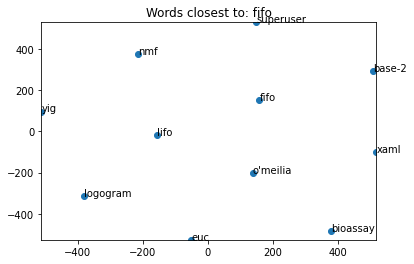

In [ ]:
display_closestwords_tsnescatterplot(glove_model, 'fifo', 100)

/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/omriram/Desktop/U/Cits4012/cits4012_environment/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


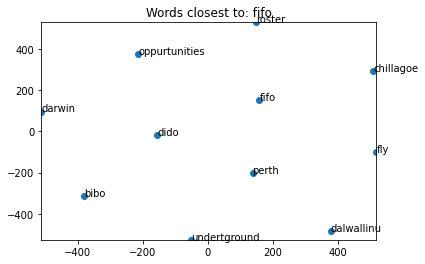

In [ ]:
display_closestwords_tsnescatterplot(word2vec_model.wv, 'fifo', 100)

The above plots better communicate how the closest words are highly dependent on the source of the dataset that the embeddings were derived from. For example perth is a close word to fifo in the word2vec model but not in the pretrained glove model.

### One hot encoding vector

Create the vocabulary class and one hot vectorizer class to one hot encode the feature column

In [ ]:
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existingmap of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                                for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = 1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}
    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)
    def add_token(self, token):
        """Update mapping dicts based on the token.
        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token
        or the UNK index if token isn't present.
        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
            for the UNK functionality
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self, index):
        """Return the token associated with the index
        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
        KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class One_hot_Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, description_vocab, target_vocab):
        """
        Args:
            description_vocab (Vocabulary): maps words to integers
            target_vocab (Vocabulary): maps class labels to integers
        """
        self.description_vocab = description_vocab
        self.target_vocab = target_vocab
    def vectorize(self, description_tokenized):
        """Create a collapsed one hot vector for the job description
        Args:
            description_tokenized (list): the tokenized job description
        Returns:
            one_hot (np.ndarray): the collapsed onehot encoding
        """
        one_hot = np.zeros(len(self.description_vocab), dtype=np.float32)
        for token in description_tokenized:
            if token not in string.punctuation:
                one_hot[self.description_vocab.lookup_token(token)] = 1
        return one_hot
    @classmethod
    def from_dataframe(cls, description_df, target_cat = True, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
            description_df (pandas.DataFrame): the description dataset
            cutoff (int): the parameter for frequency based filtering
        Returns:
            an instance of the descriptionVectorizer
        """
        description_vocab = Vocabulary(add_unk=True)
        target_vocab = Vocabulary(add_unk=False)
        # adding category or Job_type
        if target_cat:
            for category in sorted(set(description_df.category)):
                target_vocab.add_token(category)
        
        else:
            
            for job_type in  sorted(set(description_df.job_type_target)):
                target_vocab.add_token(job_type)
        # Add top words if count > provided count
        word_counts = Counter()
        for description in description_df.job_description:
            for word in description:
                if word not in string.punctuation:
                    word_counts[word] += 1
        for word, count in word_counts.items():
            if count > cutoff:
                description_vocab.add_token(word)
        return cls(description_vocab, target_vocab)
    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a descriptionVectorizer from a serializable dictionary
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the descriptionVectorizer class
        """
        description_vocab = Vocabulary.from_serializable(contents['description_vocab'])
        target_vocab = Vocabulary.from_serializable(contents['target_vocab'])
        return cls(description_vocab=description_vocab, target_vocab=target_vocab)
    def to_serializable(self):
        """Create the serializable dictionary for caching
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'description_vocab': self.description_vocab.to_serializable(),
                'target_vocab': self.target_vocab.to_serializable()}

In [ ]:
one_hot_encoder_job_type = One_hot_Vectorizer.from_dataframe(df, target_cat = False)
one_hot_encoder_job_type

## Comparing neural network models on binary and multiclass classification tasks

Define some classes to help train the classification model

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [ ]:
class emb_Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, desc_vocab, target_vocab):
        self.description_vocab = desc_vocab
        self.target_vocab = target_vocab
    def vectorize(self, description, vector_length=-1):
        """
        Args:
            description (list) : tokenized description 
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized description (numpy.array)
        """
        indices = []
        
        
        indices.extend(self.description_vocab.lookup_token(token) 
                       for token in description)
        if vector_length < 0:
            vector_length = len(indices)
        
        out_vector = np.zeros(vector_length, dtype=np.int64)
     
        out_vector[:len(indices)] = indices
       

        return out_vector

    @classmethod
    def from_dataframe(cls, df, feature_column = 'short_description', target_cat = False, cutoff=10):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
            description_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the descriptionVectorizer
        """
        target_vocab = Vocabulary(add_unk=False)
        if target_cat:
            for target in sorted(set(df.category)):
                target_vocab.add_token(target)    
        else:
            for job_type in sorted(set(df.job_type_target)):
                target_vocab.add_token(job_type)
        
 
        word_counts = Counter()
        for desc in df[feature_column]:
            desc = desc.split(' ') if type(desc) is not list else desc
            for token in desc:
                word_counts[token] += 1

        desc_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                desc_vocab.add_token(word)
        
        return cls(desc_vocab, target_vocab)

    @classmethod
    def from_serializable(cls, contents):
        description_vocab = \
            SequenceVocabulary.from_serializable(contents['description_vocab'])
        target_vocab =  \
            Vocabulary.from_serializable(contents['target_vocab'])

        return cls(description_vocab=description_vocab, target_vocab=target_vocab)

    def to_serializable(self):
        return {'description_vocab': self.description_vocab.to_serializable(),
                'target_vocab': self.target_vocab.to_serializable()}

In [ ]:
class Dataset_embedding(Dataset):
    def __init__(self, df, vectorizer, short = True, job_type = True):
        """
        Args:
            df (pandas.DataFrame): the dataset
            vectorizer (GloveVectorizer): vectorizer instatiated from dataset
        """
        self.df = df
        self._vectorizer = vectorizer
        self.short = short
        self.job_type = job_type

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context)
        if self.short:
            self._max_seq_length = max(map(measure_len, df.short_description)) + 2
        else:
            self._max_seq_length = max(map(measure_len, df.job_description)) + 2
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        if self.job_type:
            class_counts = df.job_type_target.value_counts().to_dict()
        else:
            class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.target_vocab.lookup_token(item[0])
        

        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_df_and_make_vectorizer(cls, df):
        """Load dataset and make a  vectorizer from scratch
        
        Args:
            csv (str): location of the dataset
        Returns:
            an instance of Dataset
        """
        train_df = df[df.split=='train']
        return cls(df, emb_Vectorizer.from_dataframe(train_df))

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of GloveVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return emb_Vectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        if self.short:
            description_vector = \
                self._vectorizer.vectorize(row.short_description, self._max_seq_length)
        else:
            description_vector = \
                self._vectorizer.vectorize(row.job_description, self._max_seq_length)

        if self.job_type:
            target_index = \
                self._vectorizer.target_vocab.lookup_token(row.job_type_target)
        else:
            target_index = \
                self._vectorizer.target_vocab.lookup_token(row.category)


        return {'x_data': description_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """ 
        return len(self) // batch_size

Some helper functions for the training loop

In [ ]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

The make embedding function uses a word to index dictionary for creating the embedding matrix which can be passed to the classifier

In [ ]:
glove_model.vectors

array([[-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
         0.27062 ],
       [-0.10767 ,  0.11053 ,  0.59812 , ..., -0.83155 ,  0.45293 ,
         0.082577],
       [-0.33979 ,  0.20941 ,  0.46348 , ..., -0.23394 ,  0.47298 ,
        -0.028803],
       ...,
       [ 0.36088 , -0.16919 , -0.32704 , ...,  0.27139 , -0.29188 ,
         0.16109 ],
       [-0.10461 , -0.5047  , -0.49331 , ...,  0.42527 , -0.5125  ,
        -0.17054 ],
       [ 0.28365 , -0.6263  , -0.44351 , ...,  0.43678 , -0.82607 ,
        -0.15701 ]], dtype=float32)

In [ ]:
def make_embedding_matrix(glove_model, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx = glove_model.key_to_index 
    glove_embeddings = glove_model.vectors

    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

### CNN for Binary classification

In [ ]:
cnn_args = Namespace(
    num_epochs=100, 
    early_stopping_criteria=5,
    learning_rate=0.001, 
    dropout_p=0.5, 
    batch_size=50, 
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    save_dir=os.path.join(script_dir, "model_storage/cnn"),
    model_state_file="cnn_model.pth",
    embedding_size = 100,
)
# Check CUDA
if not torch.cuda.is_available():
    cnn_args.cuda = False
    
cnn_args.device = torch.device("cuda" if cnn_args.cuda else "cpu")
print("Using CUDA: {}".format(cnn_args.cuda))
if cnn_args.expand_filepaths_to_save_dir:

    cnn_args.model_state_file = os.path.join(cnn_args.save_dir,
                                         cnn_args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(cnn_args.model_state_file))

Using CUDA: False
Expanded filepaths: 
	/Users/omriram/Desktop/U/cits4012/cits4012_project2/model_storage/cnn/cnn_model.pth


Defining the CNN classifier

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim,
     num_classes, dropout_p, pretrained_embeddings = None, padding_idx = 0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(CNNClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim = embedding_size, num_embeddings=num_embeddings, padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings)
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        self.convnet = nn.Sequential(nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU())
        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [ ]:
dataset = Dataset_embedding.load_df_and_make_vectorizer(df)
dataloader = DataLoader(dataset=dataset, batch_size=2,
                            shuffle=True, drop_last=True)

In [ ]:
vectorizer = dataset.get_vectorizer()
words = vectorizer.description_vocab._token_to_idx.keys()
embeddings = make_embedding_matrix(glove_model=glove_model, 
                                       words=words)
embeddings

array([[-0.02438249,  0.2326507 ,  0.20026919, ..., -0.16094236,
         0.11661521,  0.02024487],
       [ 0.23450515,  0.15719301, -0.11602981, ...,  0.0267947 ,
         0.13061547, -0.02480437],
       [ 0.01274723,  0.06277257,  0.10135254, ..., -0.02471936,
         0.07446384,  0.15874678],
       ...,
       [-1.13010001, -0.20182   ,  1.18970001, ..., -0.73589998,
        -0.042457  ,  0.30197001],
       [-0.00964008, -0.14158785, -0.21094804, ...,  0.17482507,
         0.09706613,  0.04792544],
       [ 0.33535999,  0.12483   , -0.19909   , ...,  0.88338   ,
        -0.031039  ,  0.21794   ]])

In [ ]:
vectorizer = dataset.get_vectorizer()
classifier = CNNClassifier(embedding_size=100, 
                            num_embeddings=len(vectorizer.description_vocab),
                            num_channels=50,
                            hidden_dim=100, 
                            num_classes=2, 
                            dropout_p=cnn_args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

classifier = classifier.to(cnn_args.device)
dataset.class_weights = dataset.class_weights.to(cnn_args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr = cnn_args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode = 'min', factor=0.5, patience=1)

train_state = make_train_state(cnn_args)

dataset.set_split('train')

classifier.float() # sets classifier to receive in double precision format
try: 
    for epoch in range(cnn_args.num_epochs):
        train_state['epoch_index'] = epoch
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, batch_size=cnn_args.batch_size, device=cnn_args.device)

        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
            y_pred = classifier(batch_dict['x_data'])
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            loss.backward()
            optimizer.step()
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t  - running_acc)/(batch_index+1)
        print('train loss',running_loss)
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=cnn_args.batch_size, device=cnn_args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier(batch_dict['x_data'])
            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
        print('val loss', running_loss)
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=cnn_args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break



except KeyboardInterrupt:
    print("Exiting loop")
    

train loss 0.6814553614122326
val loss 0.6591310996120258
train loss 0.6320010361901247
val loss 0.6164613835892435
train loss 0.5701480355607459
val loss 0.5902536976135381
train loss 0.528542978576866
val loss 0.5870290731979628
train loss 0.4915754569582191
val loss 0.6067969561633417
train loss 0.46547114181231297
val loss 0.6079118994332975
train loss 0.4313836886940232
val loss 0.6585455395407596
train loss 0.4197310002453356
val loss 0.6335551763995222
train loss 0.40373903042580733
val loss 0.6340325090844753
train loss 0.39874829104147774
val loss 0.6466611593456593
train loss 0.3906368951122442
val loss 0.6460661135487636
train loss 0.38674014013215746
val loss 0.6526923922158904
train loss 0.380602460955999
val loss 0.6728675122988426
train loss 0.3800877320838259
val loss 0.6572022331973253
train loss 0.37868101047464126
val loss 0.671422709347838
train loss 0.37599487502172785
val loss 0.6631639892772093
train loss 0.37856965661048897
val loss 0.6661481079408679
train loss

In [ ]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(cnn_args.device)
dataset.class_weights = dataset.class_weights.to(cnn_args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=cnn_args.batch_size, 
                                   device=cnn_args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.6620351765620508;
Test Accuracy: 70.96610169491524
